In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading packages and datasets

In [ ]:
pip install shap
%pip install -q hillclimbers



In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from sklearn.preprocessing import OneHotEncoder,StandardScaler

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from hillclimbers import climb_hill, partial

import warnings
warnings.filterwarnings('ignore')

In [4]:
df_train = pd.read_csv('/kaggle/input/kaggle-s4e10/playground-series-s4e10/train.csv')
df_test = pd.read_csv('/kaggle/input/kaggle-s4e10/playground-series-s4e10/test.csv')
df_train['train_id'] = 1
df_test['train_id'] = 0
df = pd.concat([df_train,df_test],axis = 0)


# 1. Understand the background and objective of this modeling exercise:

> The goal for this competition is to predict whether an applicant is approved for a loan ("loan_status"). The objective function is
[area under the ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). [Refer to the competition page for more details](https://www.kaggle.com/competitions/playground-series-s4e10)

![loan approval decision](https://defisolutions.com/wp-content/uploads/selected-1-1.png)

# 2. EDA:
    1. understand any data issue: missing/zero, and propose treatment
    2. understand the correlationship among variables to help identify outlier
    2. understand relationship between independent variables and target
    3. check data consistency between train and test datasets to ensure model prediction power


In [5]:
df.head(2)

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,train_id
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0.0,1
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0.0,1


In [54]:
# provide summary of missing and zero percentage for all variables
var = df.columns
for i in var:
    perc_missing = (df[i].isna().sum())/len(df[i])*100
    perc_zero = df[df[i] == 0].shape[0]/len(df[i])*100
    print(f"varialbe {i} has missing rate of {perc_missing:.0f}%, and zero rate of {perc_zero:.0f}%")
    

varialbe id has missing rate of 0%, and zero rate of 0%
varialbe person_age has missing rate of 0%, and zero rate of 0%
varialbe person_income has missing rate of 0%, and zero rate of 0%
varialbe person_home_ownership has missing rate of 0%, and zero rate of 0%
varialbe person_emp_length has missing rate of 0%, and zero rate of 13%
varialbe loan_intent has missing rate of 0%, and zero rate of 0%
varialbe loan_grade has missing rate of 0%, and zero rate of 0%
varialbe loan_amnt has missing rate of 0%, and zero rate of 0%
varialbe loan_int_rate has missing rate of 0%, and zero rate of 0%
varialbe loan_percent_income has missing rate of 0%, and zero rate of 0%
varialbe cb_person_default_on_file has missing rate of 0%, and zero rate of 0%
varialbe cb_person_cred_hist_length has missing rate of 0%, and zero rate of 0%
varialbe loan_status has missing rate of 40%, and zero rate of 51%
varialbe train_id has missing rate of 0%, and zero rate of 40%


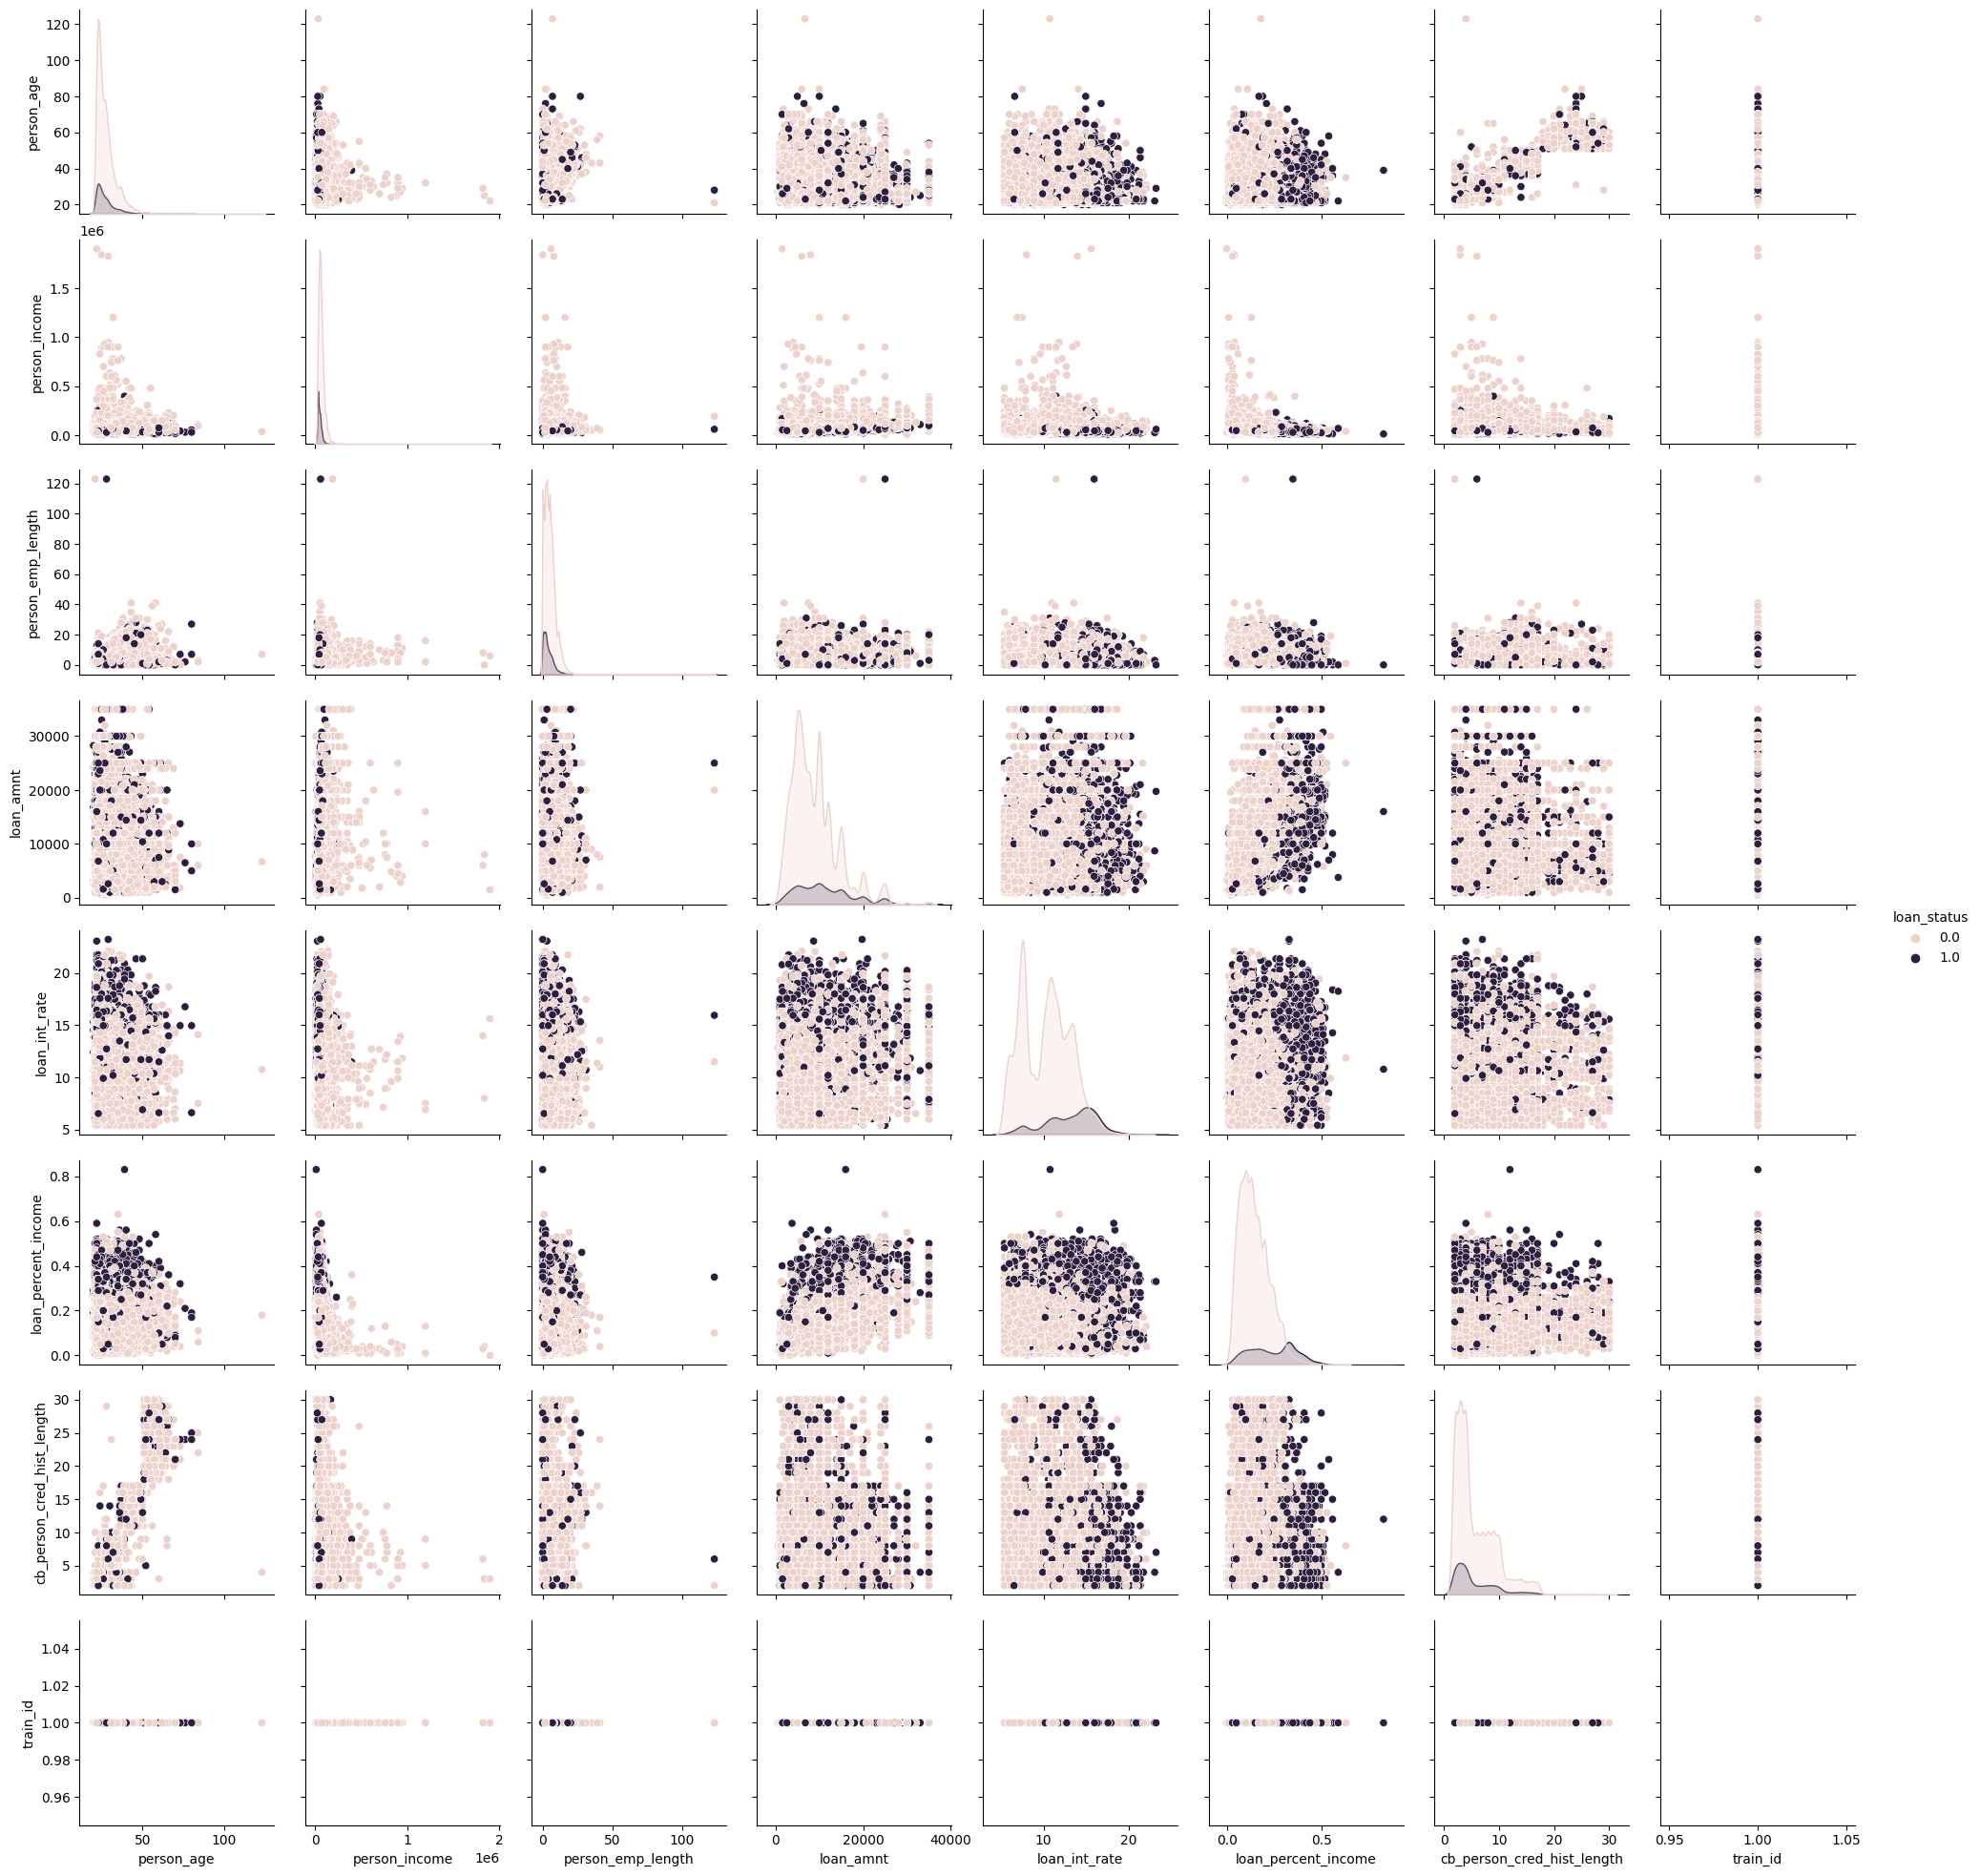

In [159]:
# Correlationship among variables
sns.pairplot(df.drop(columns = 'id'), diag_kind = 'kde', hue = 'loan_status')
plt.show()

By analyzing correlation charts, it can help: 
1. Detecting potential data quality issue, like outlier: age, employ_length
2. Making informed decisions about feature engineering

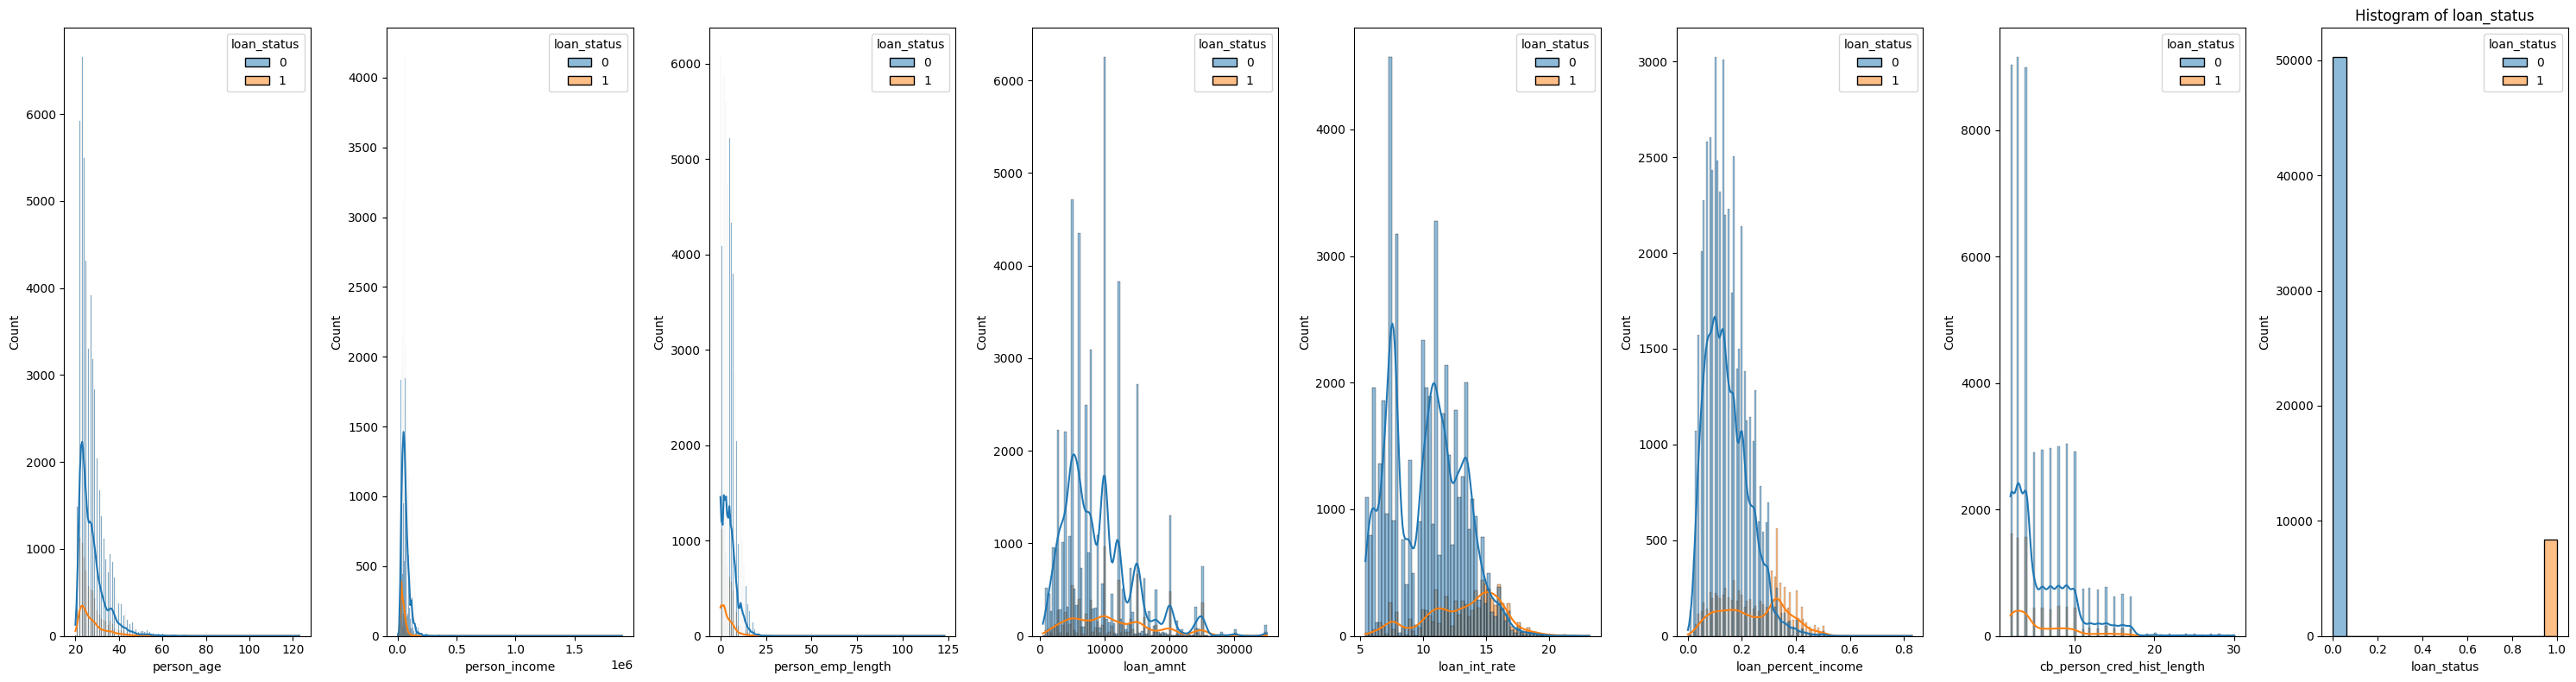

In [6]:
# Relationship chart for numerical variables and target
i = 0
hist_vars = df_train.select_dtypes(include='number').drop(columns = ['id','train_id']).columns
fig, axes = plt.subplots(nrows=1, ncols=len(hist_vars), figsize=(30, 8))

for column in hist_vars:    
    sns.histplot(data=df_train, x=column, kde=True, hue = 'loan_status',ax = axes[i])
    plt.title(f'Histogram of {column}')
    i+=1
plt.tight_layout()
plt.show()

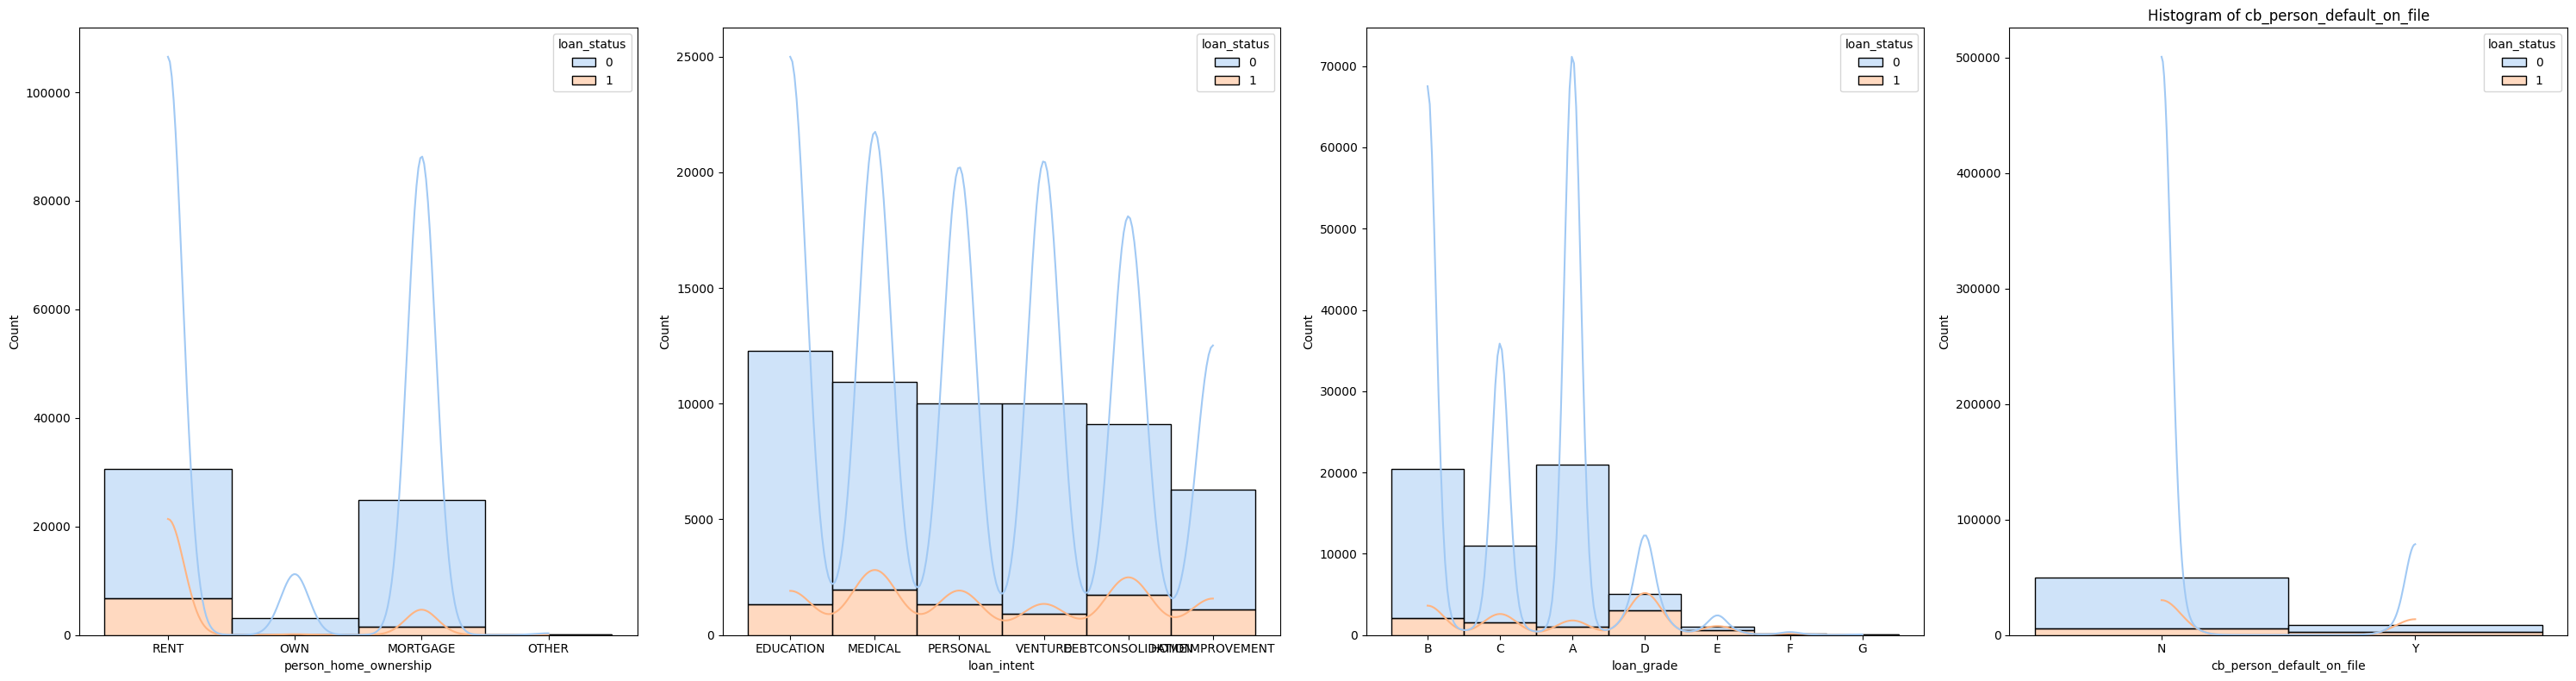

In [7]:
# Relationship chart for all categorical variables
i = 0
cat_vars = df_train.select_dtypes(include='object').columns
fig, axes = plt.subplots(nrows=1, ncols=len(cat_vars), figsize=(30, 8))

for column in cat_vars:    
    sns.histplot(data=df_train, stat="count", multiple="stack", x=column,
              kde=True, palette="pastel", hue="loan_status",
              element="bars", legend=True, ax = axes[i])
    plt.title(f'Histogram of {column}')
    i+=1
plt.tight_layout()
plt.show()

In [119]:
# Relationship bewteen categorical vars and target
aa = []
for i in cat_vars:
    bb = df[df['train_id'] == 1].groupby(i)['loan_status'].agg(['count','mean']).reset_index().rename(columns = {"mean":"loan_approval_ratio"})  
    aa.append(bb)

aa

[  person_home_ownership  count  loan_approval_ratio
 0              MORTGAGE  24824             0.059741
 1                 OTHER     89             0.168539
 2                   OWN   3138             0.013703
 3                  RENT  30594             0.222560,
          loan_intent  count  loan_approval_ratio
 0  DEBTCONSOLIDATION   9133             0.189313
 1          EDUCATION  12271             0.107734
 2    HOMEIMPROVEMENT   6280             0.173726
 3            MEDICAL  10934             0.178251
 4           PERSONAL  10016             0.132788
 5            VENTURE  10011             0.092798,
   loan_grade  count  loan_approval_ratio
 0          A  20984             0.049180
 1          B  20400             0.102304
 2          C  11036             0.135375
 3          D   5034             0.593564
 4          E   1009             0.625372
 5          F    149             0.610738
 6          G     33             0.818182,
   cb_person_default_on_file  count  loan_appr

In [11]:
# Consistency tables for all numerical variables
df_num = df.drop(columns = cat_vars)
df_num = df_num.drop(columns = 'id')

var = df_num.columns.drop(['loan_status','train_id'])

df_num.groupby(['train_id'])[var].agg(['mean','median','var','min','max','count'])


person_age                                   person_income           \
               mean median        var min  max  count          mean   median   
train_id                                                                       
0         27.566781   26.0  36.394202  20   94  39098  64060.460842  58000.0   
1         27.550857   26.0  36.399693  20  123  58645  64046.172871  58000.0   

                              ... loan_percent_income                    \
                   var   min  ...                 var  min   max  count   
train_id                      ...                                         
0         1.440645e+09  4000  ...            0.008397  0.0  0.73  39098   
1         1.438769e+09  4200  ...            0.008407  0.0  0.83  58645   

         cb_person_cred_hist_length                                   
                               mean median        var min max  count  
train_id                                                              
0                          5.830707    4.0  16.582460   2  30  39098  
1                          5.813556    4.0  16.234422   2  30  58645  

[2 rows x 42 columns]

In [12]:
# Consistency test using null hypothesis for all numerical vars
df_train_num = df_num[df_num['train_id'] == 1]
df_test_num = df_num[df_num['train_id'] == 0]


for columns in var:
    t_statistic, p_value = stats.ttest_ind(df_train_num[columns], df_test_num[columns])
    print(f"variable {columns}'s t-test statistic:{t_statistic:.2f},t-test p-value:, {p_value:.2f}" )

variable person_age's t-test statistic:-0.40,t-test p-value:, 0.69
variable person_income's t-test statistic:-0.06,t-test p-value:, 0.95
variable person_emp_length's t-test statistic:0.54,t-test p-value:, 0.59
variable loan_amnt's t-test statistic:-0.93,t-test p-value:, 0.35
variable loan_int_rate's t-test statistic:0.84,t-test p-value:, 0.40
variable loan_percent_income's t-test statistic:-0.56,t-test p-value:, 0.57
variable cb_person_cred_hist_length's t-test statistic:-0.65,t-test p-value:, 0.52


<Figure size 640x480 with 0 Axes>

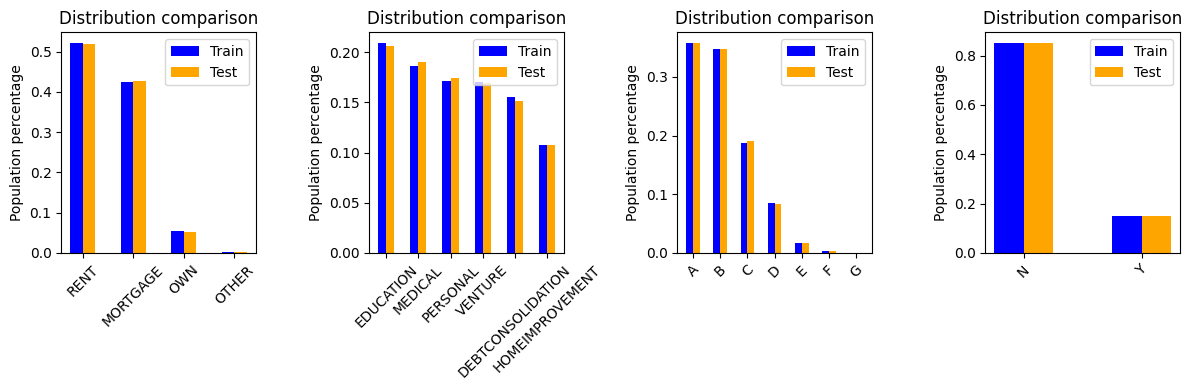

In [158]:
# Consistency chart for all categorical variables
plt.clf()

cat_var = df_train.select_dtypes(include=["object"]).columns
df_train_cat = pd.concat([df_train[cat_var],df_train['train_id']], axis = 1)
df_test_cat = pd.concat([df_test[cat_var],df_test['train_id']], axis = 1)

a = []
for columns in cat_var:
    bb = df_train_cat[columns].value_counts(normalize = True)
    cc = df_test_cat[columns].value_counts(normalize = True)
    dd = pd.concat([bb,cc],axis = 1)
    dd.columns = ['train_dis','test_dis']
    a.append(dd)

fig, axs = plt.subplots(1, 4, figsize=(12, 4))  # 1 row, 4 columns

for i in range(len(cat_var)):
    x_pos = np.arange((a[i].shape[0]))
    width = 0.25
    
    axs[i].bar(x_pos, a[i]['train_dis'], width, color='blue', label='Train')
    axs[i].bar(x_pos + width, a[i]['test_dis'], width, color='orange', label='Test')

    # Add labels, title, and legend
    #axs[i].set_xlabel("Variable")
    axs[i].set_ylabel("Population percentage")
    axs[i].set_title("Distribution comparison")
    axs[i].set_xticks(x_pos + width/2,a[i].index,rotation = 45)
    axs[i].legend()

plt.tight_layout()
plt.show()

In [14]:
# Consistency test using null hypothesis
for i in range(len(cat_var)):
    contingency_table = pd.crosstab(a[i]['train_dis'], a[i]['test_dis'])
    # Perform the Chi-square test
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"Chi-square statistic for {a[i].columns[0]}: {chi2},p-value: {p_value}")
   

Chi-square statistic for train_dis: 12.0,p-value: 0.21330930508341653
Chi-square statistic for train_dis: 30.00000000000001,p-value: 0.22428900483440337
Chi-square statistic for train_dis: 42.000000000000014,p-value: 0.226962832847802
Chi-square statistic for train_dis: 0.0,p-value: 1.0


Based on null hypothesis tests' results for both numerical and categorical variables, they show consistency across training and testing datasets, which can help ensure consistent model performance  

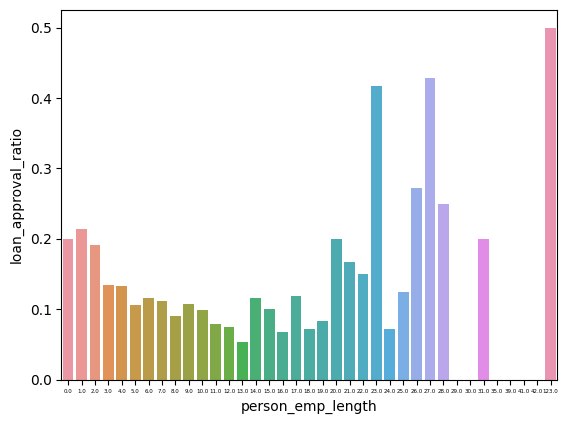

In [120]:
# deepdive on the vars with unexpected high missing/zero rate
var_summary = df.groupby("person_emp_length")['loan_status'].agg(['count','sum']).reset_index().sort_values(by = 'person_emp_length')
var_summary['loan_approval_ratio'] = var_summary['sum']/var_summary['count']

sns.barplot(data =var_summary,x='person_emp_length',y='loan_approval_ratio')
plt.xticks(fontsize = 4)
plt.show()

# 3.1 Data Preprocessing - Part I Variable Transformation

In this step, we need to consistently apply variable transformation across train and test, and based on varied data type requirement regarding different model type.

In [17]:
df = pd.concat([df_train,df_test],axis = 0)

#select all non-numercial vars
cat_var = df.select_dtypes(include=["object"]).columns
df_cat = df[cat_var]
#select non-ordinal vars
df_cat_non_ordinal = df_cat.drop(columns = ['loan_grade']).columns

#categorical vars treatment for xgboost
df_cat_non_ordinal_var = [col + '_varXG' for col in df_cat_non_ordinal]
df[df_cat_non_ordinal_var] = df[df_cat_non_ordinal].astype('category')
#categorical vars treatment for neural network, using one-hot-encoder
df_cat_encoder = OneHotEncoder(drop = 'first', sparse_output = False)
df_cat_encoded = df_cat_encoder.fit_transform(df[df_cat_non_ordinal])
df_cat_non_ordinal_varNN = [col + '_varNN' for col in df_cat_encoder.get_feature_names_out()]
df_cat_encoded = pd.DataFrame(data=df_cat_encoded, columns=df_cat_non_ordinal_varNN)
df_v = df.reset_index()
df_v1 = pd.concat([df_v,df_cat_encoded], axis = 1)
df = df_v1
#ordinal vars treatment
df['loan_grade_varCommon'] = df['loan_grade'].replace({'A': 1, 'B': 2,'C':3,'D':4,'E':5,'F':6,'G':7})
#numerical vars treatment
df_num = df_train.drop(columns = cat_var)
df_num = df_num.drop(columns = 'id')
num_var = df_num.drop(columns = ['loan_status','train_id']).columns
df_num_var = [col + '_varCommon' for col in num_var]
df[df_num_var] = df[num_var]


# 3.2 Data Preprocessing - Part II Modeling Data Creation

In [18]:
train_vf = df[df['train_id'] == 1]
test_vf = df[df['train_id'] == 0]
y = train_vf['loan_status']

In [19]:
#Modeling Data (training, validation, testing) for Xgboost, NN
X_xgboost = df.filter(like = 'varXG')
X_NN = df.filter(like = 'varNN')
X_common = df.filter(like = 'varCommon')

X_xgboost_model = pd.concat([X_common,X_xgboost],axis = 1)
X_NN_model = pd.concat([X_common,X_NN], axis = 1)

X_xgboost = X_xgboost_model.iloc[train_vf.index,:]
X_NN = X_NN_model.iloc[train_vf.index,:]
X_test_xgboost = X_xgboost_model.iloc[test_vf.index,:]
X_test_NN = X_NN_model.iloc[test_vf.index,:]

X_train_xg, X_val_xg, y_train_xg, y_val_xg = train_test_split(X_xgboost, y, test_size = 0.25, random_state = 0)
X_train_NN, X_val_NN, y_train_NN, y_val_NN = train_test_split(X_NN, y, test_size = 0.25, random_state = 0)


# 4.1 Modeling Development - XGBoost

In [20]:
# XGBoost model development
xgb = XGBClassifier(objective='binary:logistic')


cv_params = {  
               'max_depth': [5,9],
               'learning_rate': [0.03,0.05],
               'max_leaf_nodes': [60],
               'n_estimators': [1130],
               'min_weight_fraction_leaf': [0.01,0.001],
               'min_samples_leaf': [0.003], 
                  'min_samples_split': [0.1], 
               'subsample': [0.95],
            'enable_categorical': [True],
                   'verbosity': [0],
                  'random_state': [42]
               }


scoring = {'roc_auc'}

from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits = 5, random_state = 42, n_repeats = 4)

xgb_cv = GridSearchCV(xgb, cv_params, scoring = scoring, cv = rskf, refit = 'roc_auc')

xgb_cv.fit(X_train_xg, y_train_xg)

aa = pd.DataFrame(xgb_cv.cv_results_['params'])
bb = pd.DataFrame(xgb_cv.cv_results_['mean_test_roc_auc'], columns = ['mean_roc_auc'])
cc = pd.DataFrame(xgb_cv.cv_results_['std_test_roc_auc'], columns = ['std_roc_auc'])

pd.concat([bb,cc,aa], axis = 1).sort_values(by = ['mean_roc_auc'],ascending = False)

,mean_roc_auc,std_roc_auc,enable_categorical,learning_rate,max_depth,max_leaf_nodes,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,random_state,subsample,verbosity
0,0.953957,0.003333,True,0.03,5,60,0.003,0.1,0.010,1130,42,0.95,0
1,0.953957,0.003333,True,0.03,5,60,0.003,0.1,0.001,1130,42,0.95,0
4,0.952450,0.003431,True,0.05,5,60,0.003,0.1,0.010,1130,42,0.95,0
5,0.952450,0.003431,True,0.05,5,60,0.003,0.1,0.001,1130,42,0.95,0
2,0.947847,0.003781,True,0.03,9,60,0.003,0.1,0.010,1130,42,0.95,0
3,0.947847,0.003781,True,0.03,9,60,0.003,0.1,0.001,1130,42,0.95,0
6,0.945907,0.004193,True,0.05,9,60,0.003,0.1,0.010,1130,42,0.95,0
7,0.945907,0.004193,True,0.05,9,60,0.003,0.1,0.001,1130,42,0.95,0


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

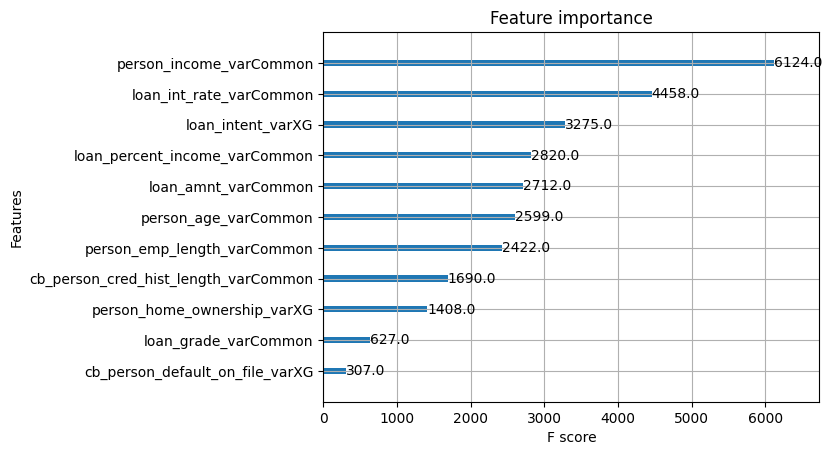

In [21]:
# Variable importance
plot_importance(xgb_cv.best_estimator_)

## 4.1.1 XGBoost Model Performance evaluation

First, let's take a look of distribution of prediction Vs. actual

In [22]:
xgb_best = {  
               'max_depth': 5,
               'learning_rate': 0.03,
               'max_leaf_nodes': 60,
               'n_estimators': 1130,
               'min_weight_fraction_leaf': 0.01,
               'min_samples_leaf': 0.0025834075077401774, 
                  'min_samples_split': 0.11732169002596993, 
               'subsample': 0.95,
            'enable_categorical': True,
                   'verbosity': 0,
                  'random_state': 42
               }

xgb_best = XGBClassifier(**xgb_best)
xgb_best.fit(X_train_xg, y_train_xg)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaf_nodes=60,
              max_leaves=None, min_child_weight=None,
              min_samples_leaf=0.0025834075077401774,
              min_samples_split=0.11732169002596993,
              min_weight_fraction_leaf=0.01, missing=nan,
              monotone_constraints=None, multi_strategy=None, ...)

In [23]:
y_val_pred = xgb_best.predict_proba(X_val_xg)[:,1]
df_y_val_pred = pd.DataFrame(y_val_pred).rename(columns = {0:"pred"})

df_y_val_xg = pd.DataFrame(y_val_xg)
df_y_val_xg = df_y_val_xg.reset_index()
data = pd.concat([df_y_val_pred,df_y_val_xg], axis = 1)

In [24]:
df_y_val_pred.describe().T

,count,mean,std,min,25%,50%,75%,max
pred,14662.0,0.142686,0.288979,0.00005,0.006074,0.020565,0.077969,0.999522


Given more than 50% of predicted value is concentrated below 0.02, we decide to create two histgram charts to view output comparison

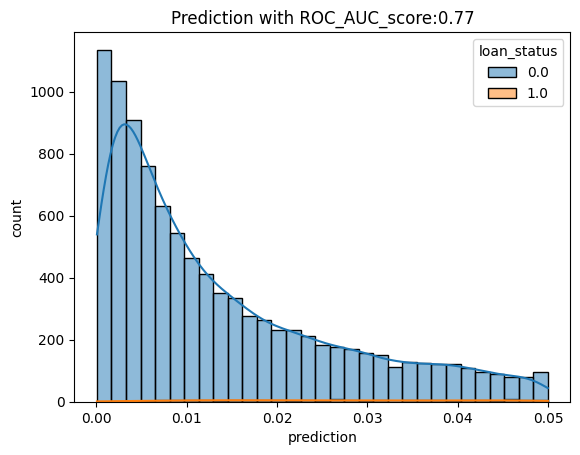

In [25]:
data_small = data[data['pred']<=0.05]
score = roc_auc_score(data_small['loan_status'],data_small['pred'])

sns.histplot(data = data_small, x = 'pred', hue = 'loan_status',kde = True)
plt.xlabel("prediction")
plt.ylabel("count")
plt.title(f"Prediction with ROC_AUC_score:{score:.2f}")
plt.show()

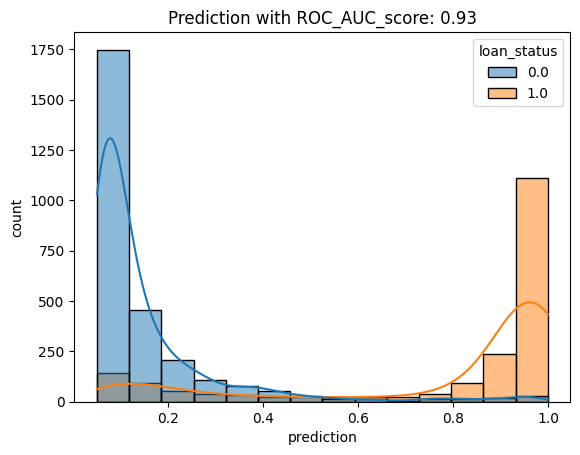

In [26]:
data_large = data[data['pred']>0.05] #for visibility purpose remove extreme small prediction value
score = roc_auc_score(data_large['loan_status'],data_large['pred'])


sns.histplot(data = data_large, x = 'pred', hue = 'loan_status',kde = True)
plt.xlabel("prediction")
plt.ylabel("count")
plt.title(f"Prediction with ROC_AUC_score: {score:.2f}")
plt.show()

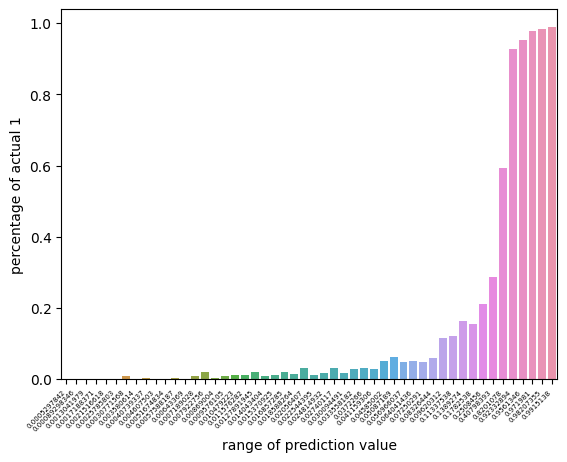

In [27]:
data['pred_bin'] = pd.qcut(data['pred'],50,labels = False)
data_bin = data.groupby(['pred_bin','loan_status'])['pred'].agg(['count','max','min']).reset_index()

data_bin1 = data_bin[data_bin['loan_status'] == 1]
data_bin0 = data_bin[data_bin['loan_status'] == 0]

data_binvf = pd.merge(data_bin0,data_bin1,on = 'pred_bin',how='left')
data_binvf_sorted = data_binvf.sort_values(by = 'pred_bin')

data_binvf_sorted.fillna(0,inplace = True)
data_binvf_sorted['pctg of 1'] = data_binvf_sorted['count_y']/(data_binvf_sorted['count_x'] + data_binvf_sorted['count_y'])

sns.barplot(data =data_binvf_sorted, x = 'max_x',y = 'pctg of 1')
plt.xlabel("range of prediction value")
plt.ylabel("percentage of actual 1")
plt.xticks(fontsize = 5, rotation = 45, horizontalalignment = 'right')
plt.show()

We expect to see "percentage of actual 1" value increase as prediction value increase, which means higher prediction value gives us higher confidence that actual value is 1. The trend of above chart makes sense, in order to further improve ROC AUC score, we need to address underestimation issue near (0.01 - 0.06) and overestimation isse (0.02) to improve model discrimination power.

Now, let's take a look at key segment level to identify under and over estimated segment

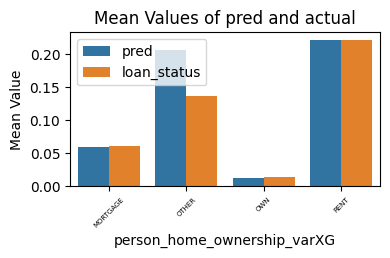

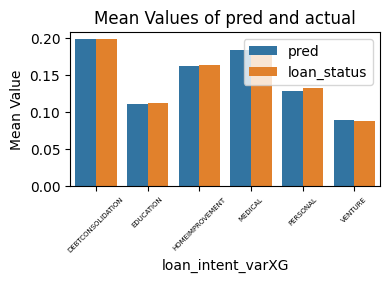

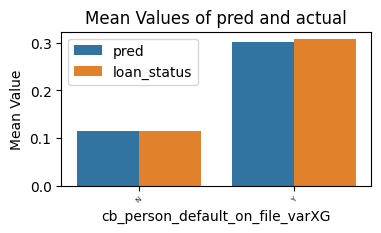

In [242]:
#fig, axs = plt.subplots(1, 3, figsize=(12, 4))  

for i in range(len(varXG)):
    aa_plot = aa[i].reset_index().melt(id_vars=varXG[i], var_name='pred', value_name='mean')
    plot = aa_plot.iloc[len(df_val_output[varXG[i]].unique()):,]
    plt.figure(figsize=(4, 2))
    sns.barplot(data = plot, x = varXG[i], y = 'mean', hue='pred')
    plt.xlabel(f"{varXG[i]}")
    plt.xticks(fontsize = 5, rotation = 45)
    plt.ylabel('Mean Value')
    plt.title('Mean Values of pred and actual')
    plt.legend()
    plt.show()


## 4.1.2 XGBoost Model Prediction Interpretation

In [28]:
#Variable impact and interpretation for one specific prediction


import shap
explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer.shap_values(X_val_xg)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_val_xg.iloc[0,:])


# Model Development Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import roc_auc_score

aa = np.arange(100,180,20)
bb = np.arange(30,70,20)
cc = []

for i in aa:
    for j in bb:

       generator = Sequential([
          Dense(i, input_dim=17,activation='relu' ),
          Dense(j, activation='relu'),
          Dense(1,activation='sigmoid')
        ])
       generator.compile(loss='binary_crossentropy', optimizer='adam')
       generator.fit(X_train_NN,y_train_NN,validation_data=(X_val_NN,y_val_NN),epochs=10, batch_size=32)
       y_pred_NN = generator.predict(X_val_NN)
       score = roc_auc_score(y_val_NN,y_pred_NN)
       print(f'for the combination of {j} and {i}, roc_auc score is: {score}')
       cc.append([j,i,score])


In [31]:
cc

[[30, 100, 0.7844462677244328],
 [50, 100, 0.8141709371021284],
 [30, 120, 0.7643370352714135],
 [50, 120, 0.8357247049099708],
 [30, 140, 0.7518029110672424],
 [50, 140, 0.8072775235419393],
 [30, 160, 0.8224086804359179],
 [50, 160, 0.8554261911900426]]

In [33]:
pd.DataFrame(cc).rename(columns = {0:"layer_1 size",1:"layer_2 size",2:"ROC_AUC"})

,layer_1 size,layer_2 size,ROC_AUC
0,30,100,0.784446
1,50,100,0.814171
2,30,120,0.764337
3,50,120,0.835725
4,30,140,0.751803
5,50,140,0.807278
6,30,160,0.822409
7,50,160,0.855426


# Model Development - Random Forest

In [34]:
rf = RandomForestClassifier(random_state=0)
scoring = {'accuracy', 'precision', 'recall', 'f1','roc_auc'}
rf_params = {  
               'n_estimators': [100,200],
            'max_depth':[5,8]
               }
rf_cv = GridSearchCV(rf,
                      rf_params,
                      scoring = scoring,
                      cv = 5,
                      refit = 'roc_auc'
                     )
rf_cv = rf_cv.fit(X_train_NN,y_train_NN)

aa = pd.DataFrame(rf_cv.cv_results_['params'])
bb = pd.DataFrame(rf_cv.cv_results_['mean_test_roc_auc'], columns = ['mean_roc_auc'])
cc = pd.DataFrame(rf_cv.cv_results_['std_test_roc_auc'], columns = ['std_roc_auc'])

pd.concat([bb,cc,aa], axis = 1).sort_values(by = ['mean_roc_auc'],ascending = False)

,mean_roc_auc,std_roc_auc,max_depth,n_estimators
3,0.930300,0.005153,8,200
2,0.929740,0.005290,8,100
1,0.918943,0.005146,5,200
0,0.917734,0.005454,5,100


# Model Development - KNN

In [35]:
scaler = StandardScaler()
X_KNN = scaler.fit_transform(X_NN_model)
X_KNN_model = pd.DataFrame(X_KNN)

X_KNN_train = X_KNN_model.iloc[train_vf.index,:]
X_KNN_test = X_KNN_model.iloc[test_vf.index,:]

X_train_KNN, X_val_KNN, y_train_KNN, y_val_KNN = train_test_split(X_KNN_train, y, test_size = 0.25, random_state = 0)


In [36]:
knn = KNeighborsClassifier(weights = 'distance', algorithm = 'ball_tree')

knn_params = {
    'n_neighbors': [5,8,10]
}
scoring = {'roc_auc'}
knn_cv = GridSearchCV(knn,knn_params, scoring = scoring, cv = 5, refit = 'roc_auc')
knn_cv.fit(X_train_KNN,y_train_KNN)

aa = pd.DataFrame(knn_cv.cv_results_['params'])
bb = pd.DataFrame(knn_cv.cv_results_['mean_test_roc_auc'], columns = ['mean_roc_auc'])
cc = pd.DataFrame(knn_cv.cv_results_['std_test_roc_auc'], columns = ['std_roc_auc'])

pd.concat([bb,cc,aa], axis = 1).sort_values(by = ['mean_roc_auc'],ascending = False)



,mean_roc_auc,std_roc_auc,n_neighbors
2,0.889874,0.005214,10
1,0.884300,0.006424,8
0,0.872598,0.006077,5


# Model Development - HillClimbers

In [38]:
y_pred_xgb = xgb_cv.predict_proba(X_xgboost)[:,1]
y_pred_test_xgb = xgb_cv.predict_proba(X_test_xgboost)[:, 1]
y_pred_NN = generator.predict(X_NN)
y_pred_test_NN = generator.predict(X_test_NN)
y_pred_rf = rf_cv.predict_proba(X_NN)[:, 1]
y_pred_test_rf = rf_cv.predict_proba(X_test_NN)[:, 1]
y_pred_KNN = knn_cv.predict_proba(X_KNN_train)[:,1]
y_pred_test_KNN = knn_cv.predict_proba(X_KNN_test)[:,1]

df_train_hc = pd.concat([X_NN,y],axis = 1)

1833/1833 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [39]:
oof_preds = {}
test_preds = {}
oof_preds['xgb'] = y_pred_xgb
oof_preds['NN'] = y_pred_NN.reshape((len(y_pred_xgb),))
oof_preds['rf'] = y_pred_rf
#oof_preds['KNN'] = y_pred_KNN
test_preds['xgb'] = y_pred_test_xgb
test_preds['NN'] = y_pred_test_NN.reshape((len(y_pred_test_xgb),))
test_preds['rf'] = y_pred_test_rf
#test_preds['KNN'] = y_pred_test_KNN

In [40]:
hill_climb_test_preds, _ = climb_hill(
    train=df_train_hc,
    oof_pred_df=pd.DataFrame(oof_preds),
    test_pred_df=pd.DataFrame(test_preds),
    target="loan_status",
    objective="maximize",
    eval_metric=partial(roc_auc_score),
    negative_weights=True,
    precision=0.001,
    plot_hill=True,
    plot_hist=False,
    return_oof_preds=True)

   /\  
  /__\  hillclimbers 
 /    \
/______\ 

Models to be ensembled | (3 total): 

xgb: 0.97802 (best solo model)
rf:  0.93917
NN:  0.85561

[Data preparation completed successfully] - [Initiate hill climbing] 

Iteration: 1 | Model added: rf | Best weight: -0.097 | Best roc_auc_score: 0.97830
Iteration: 2 | Model added: NN | Best weight: -0.005 | Best roc_auc_score: 0.97834


In [ ]:
test_id = test_vf['id']
submission = pd.DataFrame({
    "id" : test_id,
    "loan_status": hill_climb_test_preds
})

submission.to_csv('submission_ensemble_v2.csv', index=False)
# this submission receives the score of 0.95938

[Link to Competition Leaderboard for the reference](https://www.kaggle.com/competitions/playground-series-s4e10/leaderboard)